<a href="https://colab.research.google.com/github/mattprish/portfolio/blob/main/Kaggle%20notes/Kannada_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Пред

In [1]:
! pip install -q kaggle

In [2]:
! pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 42.7 MB/s eta 0:00:00


In [3]:
from google.colab import files

In [4]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"quentinspagettino","key":"c7c37fb916c5ee3208581389da96d9ae"}'}

In [5]:
! mkdir ~/.kaggle

In [6]:
! cp kaggle.json ~/.kaggle/

In [7]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [8]:
! kaggle competitions download -c Kannada-MNIST

 40% 5.00M/12.4M [00:00<00:00, 29.0MB/s]
100% 12.4M/12.4M [00:00<00:00, 55.5MB/s]


In [9]:
!unzip -q /content/Kannada-MNIST.zip

In [10]:
import pandas as pd

In [11]:
df = pd.read_csv('/content/train.csv')
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Начинаем

In [12]:
import math
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from pytorch_lightning.loggers import WandbLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy
from torchvision.datasets import ImageFolder
from tqdm import tqdm

In [13]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from IPython.display import clear_output
from torch import nn, optim
from torchvision import transforms
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
%matplotlib inline

In [14]:
from collections import defaultdict, namedtuple

import pytorch_lightning as pl
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from torchmetrics.functional import accuracy

In [15]:
def seed_everything(seed):
    # Фискирует максимум сидов.
    # Это понадобится, чтобы сравнение оптимизаторов было корректным
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(123456)

In [16]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [17]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

In [18]:
x = np.array(df.iloc[:,1:])
y = df.iloc[:,0].values

In [19]:
X, X_test, Y, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

X_train = torch.Tensor(X_train).reshape([43200,1,28,28]).to(device)
X_val =  torch.Tensor(X_val).reshape([10800,1,28,28]).to(device)
X_test = torch.Tensor(X_test).reshape([6000,1,28,28]).to(device)
y_train, y_val, y_test = torch.Tensor(y_train).to(device), torch.Tensor(y_val).to(device), torch.Tensor(y_test).to(device)

print(X_train.shape)
print(X_test.shape)

torch.Size([43200, 1, 28, 28])
torch.Size([6000, 1, 28, 28])


In [20]:
train_dataset = TensorDataset(X_train,y_train)
val_dataset = TensorDataset(X_val,y_val)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

next(iter(train_dataloader))[0].shape

torch.Size([64, 1, 28, 28])

In [21]:
# transform_train = torchvision.transforms.Compose(
#     [

#         torchvision.transforms.ColorJitter(hue=0.05, saturation=0.05),
#         torchvision.transforms.RandomHorizontalFlip(),
#         transforms.RandomHorizontalFlip(0.5),
#         transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25))
#     ]
# )

# transform_val = torchvision.transforms.Compose(
#     [
#         torchvision.transforms.ToTensor(),
#         torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
#     ]
# )


# tensor_x = torch.Tensor(x)
# tensor_y = torch.Tensor(y)

# train_dataset = TensorDataset(tensor_x,tensor_y)
# # train_dataset = TensorDataset(tensor_x,tensor_y, transform=transform_train)

# train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# # val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# train_dataset[0][0]

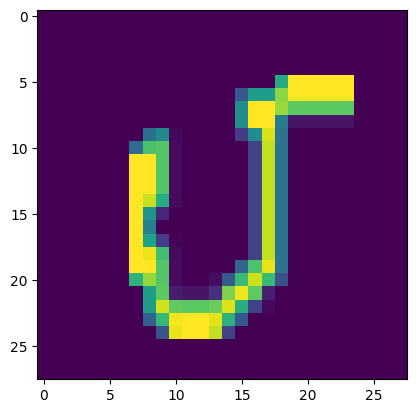

In [22]:
for batch in val_dataloader:
    images, class_nums = batch
    plt.imshow(images[5].cpu().permute(1,2,0))
    plt.show()
    break

## baseline

In [23]:
from torchvision.models import resnet50
from pytorch_lightning import Trainer
model = resnet50(pretrained = False)

In [24]:
class SimpleNet(torch.nn.Module):
    def __init__(self, dropout=0.4):

        super().__init__()

        self.batch_norm1 = torch.nn.BatchNorm2d(3)
        self.relu = torch.nn.ReLU()
        self.maxpool = torch.nn.MaxPool2d(kernel_size=2)
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
            self.relu,
            self.maxpool
        )
        self.batch_norm2 = torch.nn.BatchNorm2d(32)
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3),
            self.relu,
            self.maxpool
        )

        self.linear1 = torch.nn.Linear(in_features = 400, out_features= 1024)
        self.linear2 = torch.nn.Linear(in_features=1024, out_features=512)
        self.output = torch.nn.Linear(in_features=512, out_features=10)
        self.dropout = torch.nn.Dropout(p=dropout)

        self.loss_func = torch.nn.CrossEntropyLoss()
        self.targets = torch.Tensor()
        self.preds = torch.Tensor()

    def _forward(self, x):

        # x = x.unsqueeze(1)
        x = self.conv1(x)

        x = self.batch_norm2(x)
        x = self.conv2(x)

        x = x.view(x.size(0), -1)
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.relu(self.linear2(x))

        return self.output(x)

    def forward(self, images, target=None):
        # images ~ (batch size, num channels, height, width)
        # target ~ (batch size)
        # output ~ (batch size, num classes)
        output = self._forward(images)

        # get accuracy score and save it to self.accuracy
        if target is not None:
            loss = self.loss_func(output, target)

            self.targets = torch.cat((self.targets, target.cpu()), 0)
            pred = torch.argmax(output, dim=-1)
            self.preds = torch.cat((self.preds, pred.cpu()), 0)
            self.accuracy = accuracy(self.preds.long(), self.targets.long(), task='multiclass', num_classes=200)

        return loss if target is not None else output

    def get_accuracy(self, reset=False):
        # return accuracy by all values till now
        if reset:
            self.targets = torch.Tensor()
            self.preds = torch.Tensor()
        return self.accuracy

In [25]:
# model = ConvNet()
model = SimpleNet().to(device)
# model = resnet50(pretrained=False)
# model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,bias=False)

class WalLeModule(pl.LightningModule):
    def __init__(self) -> None:
        super().__init__()
        self.model = model
        # self.model.fc = nn.Linear(self.model.fc.in_features, 200)
        self.optimizer = torch.optim.Adam(self.model.parameters())
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x) -> torch.Tensor:
        return self.model(x)

    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds, target.long())
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx) -> None:
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target.long())
        acc = accuracy(torch.argmax(preds, dim=-1).long(), target.long(), task='multiclass', num_classes=200)
        self.log("val_loss", loss, prog_bar=True)
        self.log("accuracy", acc, prog_bar=True)

In [26]:
trainer = pl.Trainer(accelerator="cpu", max_epochs=10)
module = WalLeModule()
trainer.fit(module, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | SimpleNet        | 945 K  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
945 K     Trainable params
0         Non-trainable params
945 K     Total params
3.782     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [27]:
model.to(device)
preds = torch.argmax(model(X_test), dim=-1)

In [32]:
preds.dtype

torch.int64

In [33]:
accuracy(preds, y_test, task="multiclass", num_classes=10)

tensor(0.9907, device='cuda:0')

In [ ]:
# ids = np.arange(5000)
# df_submit = pd.DataFrame({'id': ids, 'label': preds.cpu()})
# df_submit.head()


In [ ]:
# df_submit.to_csv('submit1')

In [ ]:
# df_sample = pd.read_csv('/content/sample_submission.csv')
# df_sample